# 📈 Model Performance Metrics

In [1]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import os

from src import utils

## 1. File Prep

In [2]:
# Create the staging directory if it doesn't exist
os.makedirs(os.path.join("data", "staging"), exist_ok=True)
# Create the test folder in the staging directory if it doesn't exist
os.makedirs(os.path.join("data", "staging", "test"), exist_ok=True)
# Create train and val folders (they won't be used but need to exist for the YOLO model functions)
os.makedirs(os.path.join("data", "staging", "train"), exist_ok=True)
os.makedirs(os.path.join("data", "staging", "val"), exist_ok=True)

In [3]:
# Create the YOLO yaml file
yaml_path = os.path.join("data", "staging", "evaluation.yaml")

# YAML content
yaml_content = """
path: data/staging  # dataset root dir (leave empty for HUB)
train: train  # train images (relative to 'path')
val:   val    # val images (relative to 'path')
test:  test   # test images (relative to 'path')

names:
  0: drone
"""

# Write the YAML content to the file
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

**Experimental Design**

| **Run** | **Authentic Data** | **3D Model Data** | **Clipart Data** | **Gen AI Data** |
| --- | --- | --- | --- | --- |
| 00  | 100 | 0   | 0   | 0   |
| 01  | 26  | 27  | 23  | 24  |
| 02  | 0   | 57  | 22  | 21  |
| 03  | 0   | 27  | 73  | 0   |
| 04  | 27  | 0   | 0   | 73  |
| 05  | 27  | 33  | 40  | 0   |
| 06  | 38  | 0   | 33  | 29  |
| 07  | 38  | 33  | 29  | 0   |
| 08  | 0   | 0   | 76  | 24  |
| 09  | 0   | 24  | 52  | 24  |
| 10  | 0   | 100 | 0   | 0   |
| 11  | 27  | 73  | 0   | 0   |
| 12  | 0   | 0   | 30  | 70  |
| 13  | 29  | 0   | 36  | 35  |
| 14  | 70  | 30  | 0   | 0   |
| 15  | 72  | 0   | 0   | 28  |
| 16  | 0   | 0   | 100 | 0   |
| 17  | 26  | 35  | 0   | 39  |
| 18  | 0   | 27  | 0   | 73  |
| 19  | 0   | 70  | 30  | 0   |
| 20  | 40  | 30  | 0   | 30  |
| 21  | 27  | 0   | 73  | 0   |
| 22  | 70  | 0   | 30  | 0   |
| 23  | 0   | 0   | 0   | 100 |
| 24  | 0   | 26  | 27  | 47  |
| 25  | 0   | 72  | 0   | 28  |
| 26* | 0   | 0   | 50  | 50  |
| 27* | 0   | 50  | 0   | 50  |
| 28* | 0   | 50  | 50  | 0   |
| 29* | 0   | 33  | 33  | 33  |

`* denotes extra runs that were added`

In [4]:
# Model suffixes
# It would be better to do this by searching the directory, but this is quicker for now.
model_00 = "baseline"

model_01 = "26-27-23-24"
model_02 = "0-56-22-21"
model_03 = "0-27-73-0"
model_04 = "27-0-0-73"
model_05 = "27-33-40-0"
model_06 = "38-0-33-28"
model_07 = "38-33-28-0"
model_08 = "0-0-76-24"
model_09 = "0-24-52-24"
model_10 = "0-100-0-0"
model_11 = "27-73-0-0"
model_12 = "0-0-30-70"
model_13 = "28-0-36-35"
model_14 = "70-30-0-0"
model_15 = "72-0-0-28"
model_16 = "0-0-100-0"
model_17 = "26-35-0-39"
model_18 = "0-27-0-73"
model_19 = "0-70-30-0"
model_20 = "40-30-0-30"
model_21 = "27-0-73-0"
model_22 = "70-0-30-0"
model_23 = "0-0-0-100"
model_24 = "0-26-27-47"
model_25 = "0-72-0-28"
model_26 = "0-0-50-50"
model_27 = "0-50-0-50"
model_28 = "0-50-50-0"
model_29 = "0-33-33-33"

# Combine all model suffixes into a list
model_suffixes = [model_00,
                  model_01,
                  model_02,
                  model_03,
                  model_04,
                  model_05,
                  model_06,
                  model_07,
                  model_08,
                  model_09,
                  model_10,
                  model_11,
                  model_12,
                  model_13,
                  model_14,
                  model_15,
                  model_16,
                  model_17,
                  model_18,
                  model_19,
                  model_20,
                  model_21,
                  model_22,
                  model_23,
                  model_24,
                  model_25,
                  model_26,
                  model_27,
                  model_28,
                  model_29]

In [5]:
# Create directories if they don't exist
for suffix in model_suffixes:
    dir_path = os.path.join("model", f"model_{suffix}")
    os.makedirs(dir_path, exist_ok=True)

In [14]:
# Create a dictionary of important file paths for each model
model_paths = {
    suffix: {
        "weights": os.path.join("model", f"model_{suffix}", "weights", "best.pt"),
        "train_df": os.path.join("model", f"model_{suffix}", f"train_data_{suffix}.csv"),
        "val_df": os.path.join("model", f"model_{suffix}", f"val_data_{suffix}.csv"),
        "results_df": os.path.join("model", f"model_{suffix}", "results", f"model_performance_{suffix}.csv"),
        }
    for suffix in model_suffixes
}

## 2. Data Collection

In [7]:
# Cleanup staging directory
print("Cleaning up staging directory...")
utils.files.cleanup_staging()
print("Cleaning complete.")

Cleaning up staging directory...
Cleaning complete.


In [9]:
# Get list of testing images
test_images = utils.files.get_image_files(os.path.join(utils.PROCESSED_DATA_DIR, "testing", "test"))
print(f"Number of test images: {len(test_images)}")
print("Example image path: ", test_images[0] if test_images else "No images found")

Number of test images: 4308
Example image path:  data\processed\testing\test\2019_09_02_GOPR5871_1058_solo_frame_0000_00.png


In [11]:
# Create list of destination paths in staging directory
test_anns = utils.files.get_annotation_files(os.path.join(utils.PROCESSED_DATA_DIR, "testing", "test"))
print(f"Number of test annotations: {len(test_anns)}")
print("Example annotation path: ", test_anns[0] if test_anns else "No annotations found")

Number of test annotations: 4308
Example annotation path:  data\processed\testing\test\2019_09_02_GOPR5871_1058_solo_frame_0000_00.txt


In [12]:
# Combine lists into a dataframe
test_data = pd.DataFrame({
    "img_path": test_images,
    "ann_path": test_anns
})

In [13]:
# Copy test images/annotations to the staging directory
print("Copying test data to staging directory...")
utils.files.copy_to_staging(test_data, stage="test")
print("Copy complete.")

Copying test data to staging directory...
Copy complete.


In [17]:
# Create a combined results dataframe to store all results
combined_results_df = pd.DataFrame(columns=["data_blend", "test_map50", "test_map50-95"])

# Loop through the different models
for suffix in model_suffixes:
    
    print("=" * 50)
    print(f"Processing model_{suffix}")
    print("-" * 50)
    
    # Create a results dataframe to store the results
    metrics_df = pd.DataFrame(columns=["data_blend", "test_map50", "test_map50-95"])
    
    # Do stuff
    # Load the model
    print(f"Loading baseline model from: {model_paths[suffix]['weights']}...")
    model = YOLO(model_paths[suffix]['weights'])
    print("Model loaded.")
    print("-" * 50)
    
    # Evaluate the model on the test data
    # Assess the performance metrics (mAP50 and mAP50-95)
    print("Evaluating model performance on test data...")
    model_results = model.val(data=yaml_path, split="test", name=f"model_{suffix}_eval")
    model_map50 = model_results.box.map50
    model_map50_95 = model_results.box.map
    print("Evaluation complete.")
    print(f"mAP50: {model_map50:.4f}")
    print(f"mAP50-95: {model_map50_95:.4f}")
    print("-" * 50)
        
    # Append results to the dataframe
    print("Saving results...")
    print(f"Ensuring file path exists: {model_paths[suffix]['results_df']}")
    os.makedirs(os.path.dirname(model_paths[suffix]['results_df']), exist_ok=True)
    metrics = pd.Series({
        "data_blend": suffix,
        "test_map50": model_map50,
        "test_map50-95": model_map50_95
        })
    metrics_df = pd.concat([metrics_df, metrics.to_frame().T], ignore_index=True)
    combined_results_df = pd.concat([combined_results_df, metrics.to_frame().T], ignore_index=True)
    # Save the results dataframe
    metrics_df.to_csv(model_paths[suffix]["results_df"], index=False)
    print("Results saved.")
    
print("=" * 50)
print("All models processed.")

# Save the combined results dataframe
combined_results_path = os.path.join("reports", "model_performance_results.csv")
combined_results_df.to_csv(combined_results_path, index=False)
print("Combined results saved.")


Processing model_baseline
--------------------------------------------------
Loading baseline model from: model\model_baseline\weights\best.pt...
Model loaded.
--------------------------------------------------
Evaluating model performance on test data...
Ultralytics 8.3.221  Python-3.13.5 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2764.01545.2 MB/s, size: 403.9 KB)
val: Scanning E:\Python\synthetic-data-for-object-detection\data\staging\test.cache... 4308 images, 2743 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4308/4308 12.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 270/270 12.7it/s 21.2s<0.1s
                   all       4308       1672      0.544      0.426      0.546       0.27
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 0.2ms postprocess per image


## 3. Visualizations

In [18]:
# Read the combined results dataframe
results_df = pd.read_csv("reports\\model_performance_results.csv")

In [19]:
# Split dataframe into lists for clarity
data_blends = results_df['data_blend']
map50_scores = results_df['test_map50']
map50_95_scores = results_df['test_map50-95']

In [20]:
# Get baseline values
baseline_map50 = results_df.loc[results_df['data_blend'] == 'baseline', 'test_map50'].values[0]
baseline_map50_95 = results_df.loc[results_df['data_blend'] == 'baseline', 'test_map50-95'].values[0]
print(f"Baseline mAP50: {baseline_map50}")
print(f"Baseline mAP50-95: {baseline_map50_95}")

Baseline mAP50: 0.5459912493038382
Baseline mAP50-95: 0.2697448859430114


In [21]:
%matplotlib inline

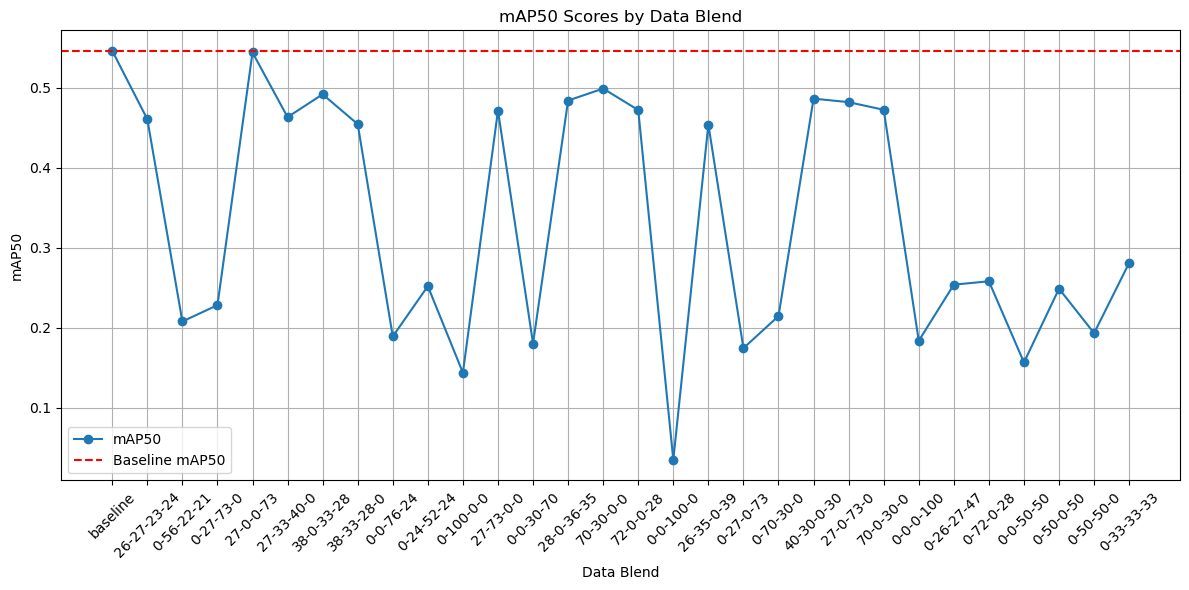

In [22]:
# Plot mAP50
plt.figure(figsize=(12, 6))
plt.plot(data_blends, map50_scores, marker='o', label='mAP50')
plt.axhline(y=baseline_map50, color='r', linestyle='--', label='Baseline mAP50')
plt.title('mAP50 Scores by Data Blend')
plt.xlabel('Data Blend')
plt.ylabel('mAP50')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


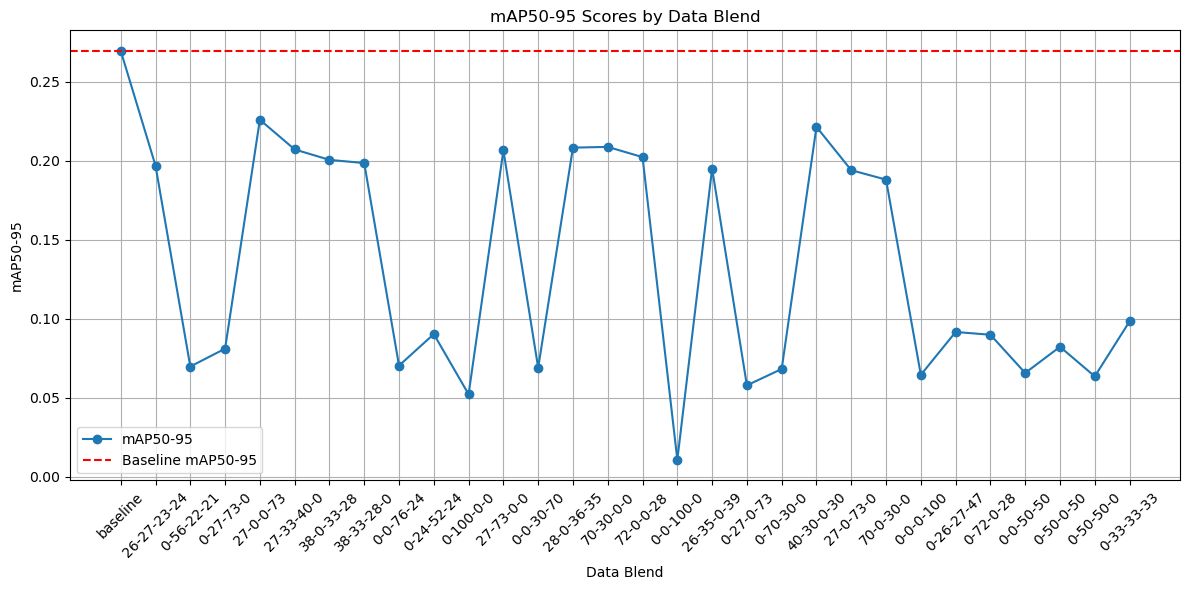

In [23]:
# Plot mAP50-95
plt.figure(figsize=(12, 6))
plt.plot(data_blends, map50_95_scores, marker='o', label='mAP50-95')
plt.axhline(y=baseline_map50_95, color='r', linestyle='--', label='Baseline mAP50-95')
plt.title('mAP50-95 Scores by Data Blend')
plt.xlabel('Data Blend')
plt.ylabel('mAP50-95')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
